# <center>Speech Denoising Using 1-D CNN</center>

In [1]:
import tensorflow as tf, librosa, numpy as np, pandas as pd, matplotlib.pyplot as plt
tf.compat.v1.disable_v2_behavior() # Disabling tensorflow v2.0 behavior
np.random.seed(7) # Set random seed for numpy
tf.random.set_random_seed(7) # Set tensorflow random seed
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Convert the audio files to spectrograms, matrices of size 513x2459
s, sr = librosa.load('train_clean_male.wav', sr = None)
S = librosa.stft(s, n_fft = 1024, hop_length = 512)
sn, sr = librosa.load('train_dirty_male.wav', sr = None)
X = librosa.stft(sn, n_fft = 1024, hop_length = 512)

In [3]:
# Printing the spectrograms
print(X)

[[ 1.29152825e-02+0.0000000e+00j  8.45048483e-03+0.0000000e+00j
  -2.07481943e-02+0.0000000e+00j ... -1.52135687e-02+0.0000000e+00j
  -4.98118671e-03+0.0000000e+00j -7.75823556e-03+0.0000000e+00j]
 [-7.06597278e-03-4.3706900e-19j -6.94738980e-03+5.1884386e-03j
   2.39305142e-02+3.3414264e-03j ...  1.20950164e-02-9.4868029e-03j
  -3.12095246e-04-1.4751647e-03j  1.96925160e-02+6.0344348e-03j]
 [ 3.11613153e-03+2.0498197e-19j -1.59678720e-02-1.7763563e-02j
   8.85831192e-03+8.3497362e-03j ... -1.23670641e-02+5.9306147e-03j
   7.67358765e-03+2.1299278e-02j -2.82987002e-02+3.5692996e-04j]
 ...
 [ 5.43509632e-05+1.1858461e-20j -4.15163022e-03-1.1022503e-03j
   1.19022408e-03-2.0613750e-03j ...  5.36997162e-04+7.6431502e-04j
  -1.19794244e-02+7.1640010e-03j -9.00672283e-03-8.2842866e-03j]
 [-4.78351954e-04+4.2351647e-19j  2.63221073e-03-1.5408223e-03j
   7.62302428e-04+5.9353854e-03j ... -3.81498365e-03-6.0208812e-03j
   5.79493213e-03-3.9956453e-03j  1.48106953e-02+1.0228334e-02j]
 [ 6.20555

In [4]:
# Getting the real valued equivalents of the spectrograms
X_mod = abs(X)
S_mod = abs(S)

In [5]:
# Dimension of the spectrograms
print(X_mod.shape, S_mod.shape)

(513, 2459) (513, 2459)


In [6]:
# Getting the transpose matrices for feeding to the 1-D CNN
X_T = X_mod.T
S_T = S_mod.T

## 1-D CNN using low-level tf.nn operations with manual definitions for:
### <ul><li>Kernel, Weight and Bias matrices</li><li>1-D Convolutions, Activation and pooling</li><li>Dropout</li><li>Fully Connected layer</li></ul>

In [7]:
CNN_1d = tf.Graph()

with CNN_1d.as_default(): 

    X_nn = tf.placeholder(dtype = tf.float32,shape = [None, 513])
    y_nn = tf.placeholder(dtype = tf.float32,shape = [None, 513])
    keep_prob = tf.placeholder(dtype = tf.float32)

    # Reshape the input | (batch_size,width) -> (batch_size,width,channels)
    X_adj = tf.reshape(tensor = X_nn, shape = [tf.shape(X_nn)[0], 513, 1])

    # Filter width in each layer
    filters1_w = 20
    filters2_w = 20
    
    # Filter number in each layer
    conv1_filter_num = 30
    conv2_filter_num = 30

    # Defining Kernels using Glorot Uniform initialization and kernel shape = (filter_width, in_channels,  out_channels)
    kernel1 = tf.get_variable("kernel1", shape = [filters1_w, 1, conv1_filter_num], initializer = tf.glorot_uniform_initializer)
    kernel2 = tf.get_variable("kernel2", shape = [filters2_w, conv1_filter_num, conv2_filter_num], initializer = tf.glorot_uniform_initializer)

    # Weight matrix and bias for the last fully connected layers initialized using Glorot Uniform Initializer
    weights_fc1 = tf.get_variable("weights_fc1", shape = [1650, 806], initializer = tf.glorot_uniform_initializer)
    bias_fc1 = tf.get_variable("bias_fc1", shape = [806], initializer = tf.glorot_uniform_initializer)
    weights_fc2 = tf.get_variable("weights_fc2", shape = [806, 513], initializer = tf.glorot_uniform_initializer)
    bias_fc2 = tf.get_variable("bias_fc2", shape = [513], initializer = tf.glorot_uniform_initializer)

    # Complex convolution layer 1
    conv1 = tf.nn.conv1d(value = X_adj, filters = kernel1, padding = 'VALID', stride = 2)
    act1 = tf.nn.relu(conv1)
    drop1 = tf.nn.dropout(act1, keep_prob)
    pool1 = tf.layers.max_pooling1d(inputs = drop1, pool_size = 5, padding = 'valid', strides = 2)

    # Complex convolution layer 2
    conv2 = tf.nn.conv1d(value = drop1, filters = kernel2, padding = 'VALID', stride = 2)
    act2 = tf.nn.relu(conv2)
    drop2 = tf.nn.dropout(act2, keep_prob)
    pool2 = tf.layers.max_pooling1d(inputs = drop2, pool_size = 5, padding = 'valid', strides = 2)

    # Fully connected layer 1
    fc_input = tf.layers.flatten(pool2)
    fc1 = tf.add(tf.matmul(fc_input, weights_fc1), bias_fc1)
    fc1_act = tf.nn.relu(fc1)

    # Fully connected layer 2
    fc2 = tf.add(tf.matmul(fc1_act, weights_fc2), bias_fc2)
    
    fc_act = tf.nn.relu(fc2) # Final output

    loss = tf.reduce_sum(tf.squared_difference(fc_act, y_nn))
    optimizer = tf.train.AdamOptimizer(1e-04).minimize(loss)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.MaxPooling1D instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


## Training the 1-D CNN Model

In [8]:
with CNN_1d.as_default():
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    max_epochs = 1000
    batch_size = 19
    progbar = tf.keras.utils.Progbar(max_epochs)
    train_losses = []

    for epoch in range(max_epochs):
        random_batches = np.random.choice(X_T.shape[0], size = (int(513/batch_size), batch_size))
        loss_epoch = []
        for batch_num in range(random_batches.shape[0]): # Keep last batch for validation
            loss_batch,_ = sess.run([loss, optimizer], feed_dict = {X_nn : X_T[random_batches[batch_num]], y_nn : S_T[random_batches[batch_num]], keep_prob : 0.8})
            loss_epoch.append(loss_batch)

        train_losses.append(sum(loss_epoch)/len(loss_epoch))
        progbar.update(epoch+1)

1000/1000 [==============================] - 363s 363ms/step


## Plot of Loss vs Epochs 

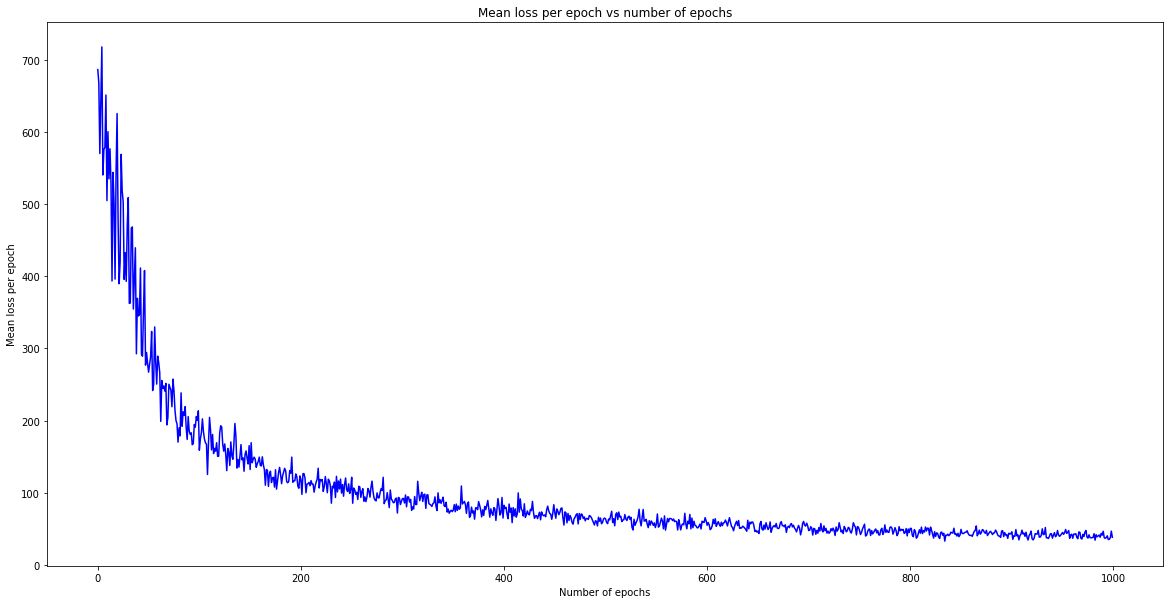

In [9]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot([i for i in range(max_epochs)],train_losses,'b')
plt.title("Mean loss per epoch vs number of epochs")
plt.ylabel("Mean loss per epoch")
plt.xlabel("Number of epochs")
plt.show()

## Obtaining the prediction for training signal with 1-D CNN

In [10]:
S_T1_predicted_T = sess.run(fc_act,{X_nn: X_T, keep_prob: 1}) # Feed train data to the 1-D CNN to get the output
S_T1_predicted = S_T1_predicted_T.T                          # Take the transpose
S_T1_hat = np.multiply(np.divide(X,X_mod), S_T1_predicted)  # The predicted S_hat
S_T1 = librosa.istft(S_T1_hat, hop_length = 512)           # Apply inverse STFT using librosa
librosa.output.write_wav('train_1D_recon.wav', S_T1, sr)

## SNR of the training audio signal
## SNR = 10 log<sub>10</sub> $\frac{\sum_{t}^{} ( s ( t ) )^2} {\sum_{t}^{} ( s ( t ) - \hat{s} ( t ) )^2}$ 

In [11]:
# Formula to calculate SNR
snr = 10 * np.log10(np.sum(np.square(S)) / np.sum(np.square(np.subtract(S, S_T1_hat))))
print("SNR of reconstructed training signal = ", abs(snr), "db")

SNR of reconstructed training signal =  15.826036004466033 db


## Testing the 1-D CNN model on test signal 1 (test_x_01.wav)

In [12]:
s3, sr = librosa.load('test_x_01.wav', sr = None)
T1 = librosa.stft(s3, n_fft = 1024, hop_length = 512) # STFT on test_x_01
T1_mod = np.abs(T1) # Magnitude of Test signal
T1_T = T1_mod.T     # Transpose
with CNN_1d.as_default():
    S_T1_predicted_T = sess.run(fc_act,{X_nn:T1_T,keep_prob:1})
S_T1_predicted = S_T1_predicted_T.T         # Take the transpose
S_T1_hat = np.multiply(np.divide(T1,T1_mod),S_T1_predicted)  # The predicted S_hat
S_T1 = librosa.istft(S_T1_hat,hop_length=512)   # Apply inverse STFT
librosa.output.write_wav('test_s_01_1D_CNN_recon.wav', S_T1, sr)

## Testing the 1-D CNN model on test signal 2 (test_x_02.wav)

In [13]:
s3, sr = librosa.load('test_x_02.wav', sr = None)
T1 = librosa.stft(s3, n_fft = 1024, hop_length = 512) # STFT on test_x_02
T1_mod = np.abs(T1) # Magnitude of T1
T1_T = T1_mod.T     # Transpose
with CNN_1d.as_default():
    S_T1_predicted_T = sess.run(fc_act,{X_nn:T1_T,keep_prob:1})
S_T1_predicted = S_T1_predicted_T.T # Transpose
S_T1_hat = np.multiply(np.divide(T1,T1_mod),S_T1_predicted) # Predicted S_hat
S_T1 = librosa.istft(S_T1_hat,hop_length=512) # Inverse STFT
librosa.output.write_wav('test_s_02_1D_CNN_recon.wav', S_T1, sr)

In [14]:
sess.close() # End the session